# 0.0. IMPORTACOES

In [126]:
import pandas                   as pd
import matplotlib.pyplot        as plt
import numpy                    as np
import seaborn                  as sns
import plotly.express           as px
import plotly.graph_objects     as go
import pickle                   as pk

from xgboost                    import XGBRegressor
from plotly.subplots            import make_subplots
from sklearn                    import set_config
from sklearn.model_selection    import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.pipeline           import Pipeline
from sklearn.preprocessing      import MinMaxScaler
from sklearn.linear_model       import LinearRegression, Lasso
from sklearn.metrics            import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, make_scorer, r2_score
from sklearn.ensemble           import RandomForestRegressor
from sklearn.compose            import ColumnTransformer
from category_encoders          import TargetEncoder

## 0.1. Funcoes

In [246]:
#MPE (Diz a porcentagem que o nosso modelo esta prevendo a mais ou a menos do que deveria, em média)
def mean_percentage_error(y_true, y_hat):
    return np.mean( (y_true - y_hat)/y_true )


#retorna um dataframe contendo informações sobre os erros (MAE, MAPE e RMSE)
def ml_error(model_name, y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    mape = mean_absolute_percentage_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    r2 = r2_score(y_true, y_hat)
    mpe = mean_percentage_error(y_true, y_hat)
    
    return pd.DataFrame({'Model Name': [model_name],
                        'MAE': [mae],
                        'MAPE': [mape],
                        'RMSE': [rmse],
                        'R2' : [r2],
                        'MPE' : [mpe]}).round(4)


#funcao que aplica cross-validation em um dataset e retorna métricas como MAE, MAPE, RMSE e seus desvios padrões
def cross_validation(model_name, model, X, y, cv):
    k = cv
    kf = KFold(n_splits=k)

    scoring = {
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
        'RMSE': make_scorer(mean_squared_error, greater_is_better=False),
        'R2': make_scorer(r2_score),
        'MPE': make_scorer(mean_percentage_error, greater_is_better=False)
    }

    results = cross_validate(model, X, y, cv=kf, scoring=scoring)

    mae_scores = [-x for x in results['test_MAE']]
    mape_scores = [-x for x in results['test_MAPE']]
    rmse_scores = [-x for x in results['test_RMSE']] 
    r2_scores = results['test_R2']
    mpe_scores = [-x for x in results['test_MPE']]
        
    return pd.DataFrame({
        'Model Name': [model_name],
        'MAE_mean': [f'{round(np.mean(mae_scores), 2)}'],
        'MAE_std' : [f'{round(np.std(mae_scores), 4)}'],
        'MAPE_mean': [f'{round(np.mean(mape_scores), 4)}'],
        'MAPE_std': [f'{round(np.std(mape_scores), 4)}'],
        'RMSE_mean': [f'{round(np.mean(np.sqrt(rmse_scores)), 2)}'],
        'RMSE_std': [f'{round(np.std(np.sqrt(rmse_scores)), 4)}'],
        'R2_mean' : [f'{round(np.mean(r2_scores), 4)}'],
        'R2_std' : [f'{round(np.std(r2_scores), 4)}'],
        'MPE_mean' : [f'{round(np.mean(mpe_scores), 4)}'],
        'MPE_std' : [f'{round(np.std(mpe_scores), 4)}']
    })



## 0.1. Extração dos Dados

In [128]:
df_raw = pd.read_csv('dataset/insurance.csv')

# 1.0. ENTENDENDO OS DADOS

In [129]:
df1 = df_raw.copy()

In [130]:
# verifica as cinco primeiras linhas
df1.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1.1. Dimensões do dataset (linhas x colunas)

In [131]:
print(f'O dataset tem {df1.shape[0]} linhas e {df1.shape[1]} colunas.')

O dataset tem 1338 linhas e 7 colunas.


O dataset contém 7 colunas, sendo elas:
- age : Idade do cliente
- sex : O sexo do cliente
- bmi : IMC do cliente
- children : Quantidade de dependentes
- smoker : variável que informa se o cliente é fumante ou não
- region : região em que o cliente mora
- charges : Valor anual pago pelo cliente (em dólares americanos)

## 1.2. Tipos de dados

In [132]:
df1.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

- Temos colunas com os seguintes tipos de dados: Inteiros, Objetos e Floats.

## 1.3. Verifica se há valores faltantes

In [133]:
df1.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

- Como observado acima, não há valores faltantes.

## 1.4. Estatística Descritiva

In [134]:
#seleciona colunas numericas
num_attributes = df1.select_dtypes(include=['int', 'float'])

#seleciona colunas categoricas
cat_attributes = df1.select_dtypes(include=['object'])

### 1.4.1. Atributos Numéricos

In [135]:
# Tendencia Central - Media, mediana
# Dispercao - std, min, max, range, skew, kurtosis

num_statistics = pd.DataFrame({'min': num_attributes.min(),
                               'max': num_attributes.max(),
                               'media': num_attributes.mean(),
                               'mediana': num_attributes.median(),
                               'desvio_padrao': num_attributes.std(),
                               'amplitude': num_attributes.max() - num_attributes.min(),
                               'skewness' : num_attributes.skew(),
                               'curtose' : num_attributes.kurtosis()})

num_statistics

,min,max,media,mediana,desvio_padrao,amplitude,skewness,curtose
age,18.0000,64.00000,39.207025,39.000,14.049960,46.00000,0.055673,-1.245088
bmi,15.9600,53.13000,30.663397,30.400,6.098187,37.17000,0.284047,-0.050732
children,0.0000,5.00000,1.094918,1.000,1.205493,5.00000,0.938380,0.202454
charges,1121.8739,63770.42801,13270.422265,9382.033,12110.011237,62648.55411,1.515880,1.606299


- Acima temos algumas estatísticas, dentre elas temos a skewness (assimetria) que nos diz se a variável se aproxima de uma distribuição normal (quanto mais próximo de 0, mais se aproxima).

- Temos também a curtose, que nos informa sobre o grau de achatamento da curva. Por exemplo, caso o valor da curtose seja 0, a distribuição se aproxima de uma normal. Já se tivermos um valor alto para a curtoso, isso indica que temos uma distribuição mais concentrada em torno da média e com maior probabilidade de haver outliers. Já uma curtose negativa indica que os dados são mais dispersos e com baixas probabilidades de haver outliers.

## 1.4.2. Atributos Categóricos

In [136]:
# numero de valores unicos para cada variavel
cat_attributes.apply(lambda x: x.nunique(), axis=0)

sex       2
smoker    2
region    4
dtype: int64

In [137]:
#cria o dashboard com 3 colunas e 1 linha
fig = make_subplots(rows= 1, cols= 3)

#cria graficos boxplot
for i, col in enumerate(cat_attributes.columns):
    fig.add_trace(go.Box(x = df1[col],
                         y = df1['charges'],
                         name= col), row=1, col=i+1)
    
# Atualiza o layout do dashboard
fig.update_layout(height=600, width=900, 
                  title_text="Dados Categóricos x Valor Pago Pelo Cliente", 
                  title=dict(x=0.5))

# Exibe o dashboard
fig.show()

- O gráfico acima indica que usuários que são fumantes tendem a pagar mais pelo plano de saúde.
- Além disso, aparentemente o sexo e a região não exergem tanta influência sobre os valores pagos.

# 2.0. ANALISE EXPLORATORIA DE DADOS

In [138]:
df2 = df1.copy()

## 2.1. Análise Univariada

### Variável Resposta

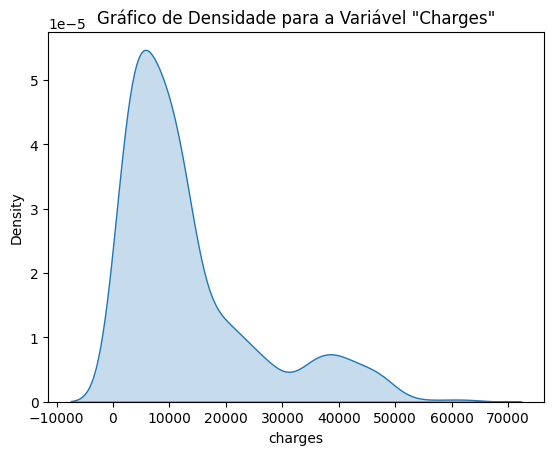

In [139]:
#distribuição da variável resposta
sns.kdeplot(df2['charges'], fill=True).set(title = 'Gráfico de Densidade para a Variável "Charges"');

### Variáveis Numéricas

In [140]:
#cria o dashboard

# Define o número de colunas do dashboard
num_cols = 2

# Calcula o número de linhas necessárias
num_rows = len(num_attributes.columns) // num_cols + (len(num_attributes.columns) % num_cols > 0)

fig = make_subplots(rows= num_rows, cols= num_cols)

for i, column in enumerate(num_attributes.columns):
    row = i // num_cols + 1
    col = i % num_cols + 1
    
    fig.add_trace(go.Histogram(x=num_attributes[column], name = column), row= row, col=col)

# Atualiza o layout do dashboard
fig.update_layout(height=400*num_rows, width=900, title_text="Distribuição das Variáveis Numéricas", bargap=0.4, title = dict(x=0.5))


# Exibe o dashboard
fig.show()

### Variáveis Categóricas

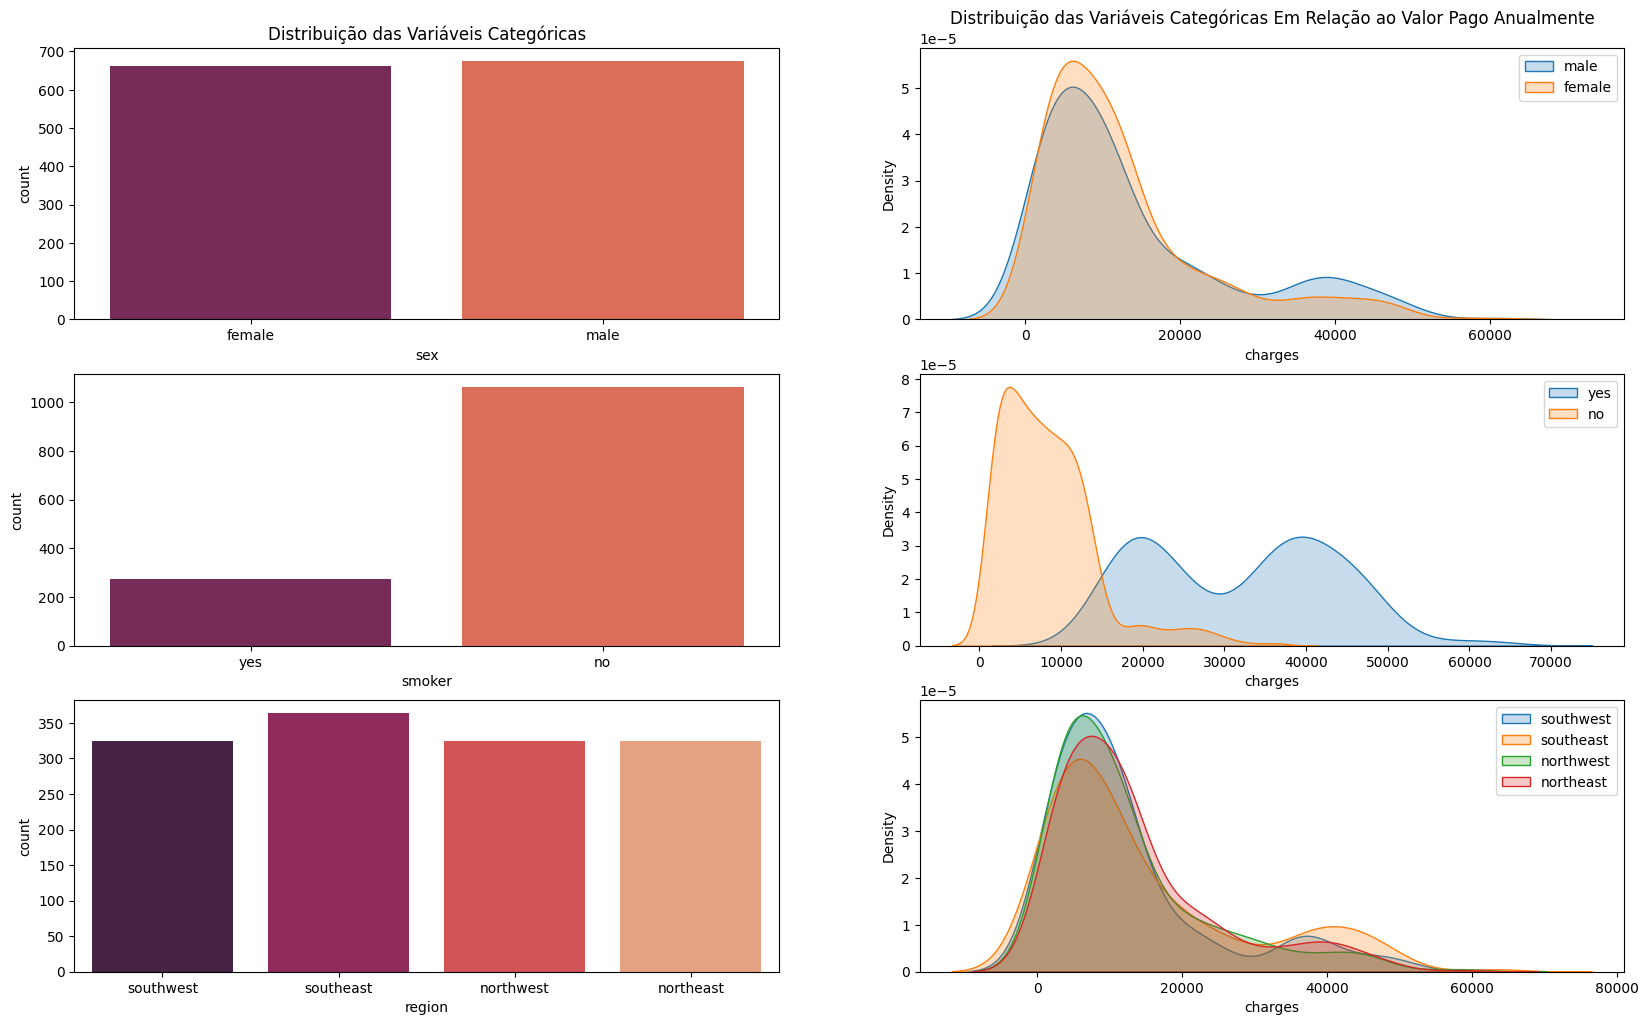

In [141]:
plt.figure(figsize=(20,12), )

#sex
plt.subplot(3,2,1)
sns.countplot(data= df2, x = 'sex', palette='rocket').set(title='Distribuição das Variáveis Categóricas')

plt.subplot(3,2,2)
sns.kdeplot(data=df2[df2['sex'] == 'male']['charges'], 
            fill=True,
            label='male')

sns.kdeplot(data=df2[df2['sex'] == 'female']['charges'], 
            fill=True,
            label='female').set(title='Distribuição das Variáveis Categóricas Em Relação ao Valor Pago Anualmente')

plt.legend()

#smoker
plt.subplot(3,2,3)
sns.countplot(data= df2, x = 'smoker', palette='rocket')

plt.subplot(3,2,4)
sns.kdeplot(data=df2[df2['smoker'] == 'yes']['charges'], 
            fill=True,
            label='yes')

sns.kdeplot(data=df2[df2['smoker'] == 'no']['charges'], 
            fill=True,
            label='no')

plt.legend()

#region
plt.subplot(3,2,5)
sns.countplot(data= df2, x = 'region', palette='rocket')

plt.subplot(3,2,6)
sns.kdeplot(data=df2[df2['region'] == 'southwest']['charges'], 
            fill=True,
            label='southwest')

sns.kdeplot(data=df2[df2['region'] == 'southeast']['charges'], 
            fill=True,
            label='southeast')

sns.kdeplot(data=df2[df2['region'] == 'northwest']['charges'], 
            fill=True,
            label='northwest')

sns.kdeplot(data=df2[df2['region'] == 'northeast']['charges'], 
            fill=True,
            label='northeast')

plt.legend();

- Do gráfico acima podemos observar que pessoas que fumam normalmente pagam bem mais

## 2.2. Análise Bivariada

### H1. Pessoas com 50 anos ou mais pagam, em média, mais que pessoas de idade inferior.


Verdade! Pessoas com 50 anos ou mais tendem a pagar 57% a mais, em média.

In [142]:
#cria dataset auxiliar
df_temp = df2.copy()
df_temp['>=50'] = 0
df_temp.loc[df_temp['age'] >= 50, '>=50'] = 1
aux = df_temp.groupby('>=50').agg({'charges' : 'mean'}).reset_index()

#cria grafico
fig = go.Figure()

fig.add_trace(go.Bar(x = aux['>=50'], y=aux['charges']))

fig.update_layout(xaxis_title = 'Possui idade igual ou superior a 50 anos?',
                  yaxis_title = 'Valor Anual Pago',
                  xaxis = (dict(ticktext = ['Não', 'Sim'],
                                tickvals = [0, 1])))

fig.show()

In [143]:
#calculo

round((aux[aux['>=50'] == 1]['charges'].item() / aux[aux['>=50'] == 0]['charges'].item() - 1)*100, 2)

57.05

### H2. Pessoas do sexo masculino pagam, em média, 10% a mais que pessoas do sexo feminino.

Verdade! Homens tendem a pagar 11% a mais que mulheres, em média.

In [144]:
#cria dataset auxiliar
aux = df_temp.groupby('sex').agg({'charges' : 'mean'}).reset_index()

#cria grafico
fig = go.Figure()

fig.add_trace(go.Bar(x = aux['sex'], y=aux['charges']))

fig.update_layout(title_text = 'Sexo x Valor Anual Pago',
                  title = dict(x = 0.5))

fig.show()

In [145]:
# calculo

((aux.loc[aux['sex'] == 'male', 'charges'].item() / aux.loc[aux['sex'] == 'female', 'charges'].item()) - 1) * 100

11.035949184302819

### H3. Pessoas com IMC igual ou maior a 30 pagam, em média, 50% a mais que pessoas com imc abaixo de 30.


Parcialmente verdade! Pessoas com IMC igual ou superior a 30 tendem a pagar, em média, 45% a mais.

In [146]:
#cria dataset auxiliar
df_temp = df2.copy()
df_temp['>=30'] = 0
df_temp.loc[df_temp['bmi'] >= 30, '>=30'] = 1
aux = df_temp.groupby('>=30').agg({'charges' : 'mean'}).reset_index()

#cria grafico
fig = go.Figure()

fig.add_trace(go.Bar(x = aux['>=30'], y=aux['charges']))

fig.update_layout(xaxis_title = 'Possui IMC igual ou superior a 30?',
                  title_text  = 'IMC x Valor Anual Pago',
                  title = dict(x=0.5),
                  yaxis_title = 'Valor Anual Pago',
                  xaxis = (dict(ticktext = ['Não', 'Sim'],
                                tickvals = [0, 1])))

fig.show()

In [147]:
# calculo

round(((aux.loc[aux['>=30'] == 1, 'charges'].item() / aux.loc[aux['>=30'] == 0, 'charges'].item()) - 1) * 100, 2)

45.16

### H4. Indivíduos com idade abaixo de 25 anos pagam menos que aqueles que têm idade igual ou acima de 25.


Verdade! Pessoas com menos de 25 anos tendem a pagar menos, em média.

In [148]:
#cria dataset auxiliar
df_temp = df2.copy()
df_temp['<25'] = 1
df_temp.loc[df_temp['age'] >= 25, '<25'] = 0
aux = df_temp.groupby('<25').agg({'charges' : 'mean'}).reset_index()

#cria grafico
fig = go.Figure()

fig.add_trace(go.Bar(x = aux['<25'], y=aux['charges']))

fig.update_layout(xaxis_title = 'Possui idade inferior a 25 anos?',
                  title_text  = 'Idade x Valor Anual Pago',
                  title = dict(x=0.5),
                  yaxis_title = 'Valor Anual Pago',
                  xaxis = (dict(ticktext = ['Não', 'Sim'],
                  tickvals = [0, 1])))

fig.show()

### H5. Fumantes pagam, em média, 40% a mais que pessoas não fumantes


Incorreto! Fumantes pagam muito mais que não fumantes. 280% a mais em média.

In [149]:
#cria dataset auxiliar
aux = df_temp.groupby('smoker').agg({'charges' : 'mean'}).reset_index()

#cria grafico
fig = go.Figure()

fig.add_trace(go.Bar(x = aux['smoker'], y=aux['charges']))

fig.update_layout(title_text = 'Fumante x Não Fumante',
                  yaxis_title = 'Valor Anual Pago',
                  xaxis_title = 'É Fumante?',
                  title = dict(x = 0.5))

fig.show()

In [150]:
# calculo

round(((aux.loc[aux['smoker'] == 'yes', 'charges'].item() / aux.loc[aux['smoker'] == 'no', 'charges'].item()) - 1) * 100, 2)

280.0

In [151]:
#relação entre sexo x fumante x valor pago

#cria dataset auxiliar
aux = df_temp.groupby(['sex', 'smoker']).agg({'charges' : 'mean'}).reset_index()

# Cria o gráfico usando o Plotly

fig = px.bar(aux, x = 'sex', y = 'charges', color = 'smoker', barmode='group')
fig.update_layout(title_text = 'Comparação entre genêro, condição de fumante e valores pagos',
                  title = dict(x=0.5),
                  yaxis_title = 'Valor Anual Pago',
                  xaxis_title = 'Sexo')

fig.show()

- Acima, verificamos que independente do sexo fumantes tendem a pagar mais que não fumantes

### H6. Indivíduos que moram na região 'southwest' gastam mais com seguro de saúde, em média.

Falso. Os números são equilibrado, porém na região "southeast" há a tendência de se gastar mais com plano de saúde.

In [152]:
#cria dataset auxiliar
aux = df_temp.groupby('region').agg({'charges' : 'mean'}).reset_index()

#cria grafico
fig = go.Figure()

fig.add_trace(go.Bar(x = aux['region'], y=aux['charges']))

fig.update_layout(title_text = 'Regiões x Valor Pago Anualmente',
                  yaxis_title = 'Valor Anual Pago',
                  xaxis_title = 'Região',
                  title = dict(x = 0.5))

fig.show()

### H7. Quanto maior o número de dependentes, maior o valor pago.

Falso. O número de dependentes não parece afetar tanto o valor pago pelo cliente.

In [153]:
#cria dataset auxiliar
aux = df_temp.groupby('children').agg({'charges' : 'mean'}).reset_index()

#cria grafico
fig = px.bar(aux, x='children', y = 'charges')

fig.update_layout(title_text = 'Nº de Dependentes x Valor Anual Pago',
                  title = dict(x = 0.5),
                  xaxis_title = 'Nº de Dependentes',
                  yaxis_title = 'Valor Anual Pago')

fig.show()

## 2.3. Análise Multivariada

<Axes: >

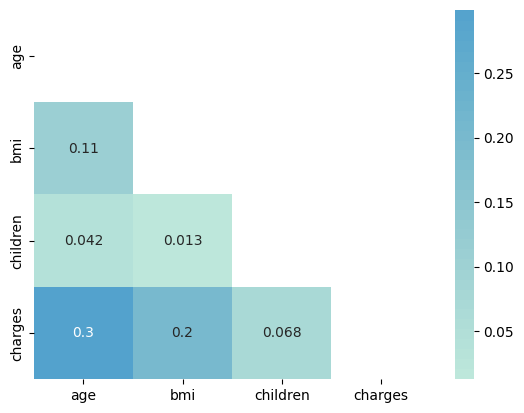

In [154]:
#matriz de correlação

corr = num_attributes.corr(method='pearson')
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask = matrix, center=1)

# 3.0. PREPARACAO DOS DADOS

In [155]:
df3 = df2.copy()

#split

X = df3.drop(columns=['charges'])
y = df3.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## 3.1. Transformação e Normalização

In [156]:
# Definindo as colunas categóricas
categorical_features = ['sex', 'smoker', 'region']

set_config(transform_output="pandas")

# Criando o transformador para as colunas categóricas
categorical_transformer = Pipeline([('target_encoder', TargetEncoder())])

# Criando o ColumnTransformer para aplicar o TargetEncoder apenas nas colunas categóricas
cat_transf = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Criando o pipeline completo com o MinMaxScaler para normalizar os dados
preprocessor = Pipeline([
    ('cat_transf', cat_transf),
    ('scaler', MinMaxScaler())
])

# Aplicando as transformações nos dados
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)


In [157]:
#salva transformações
#pk.dump(preprocessor, open('preprocessor.pkl', 'wb'))

# 4.0. MODELAGEM

## 4.1. Regressão Linear 

In [248]:
#cria modelo
lr = LinearRegression()
lr.fit(X_train_preprocessed, y_train)

#predict
yhat_lr = lr.predict(X_train_preprocessed)

#performance sem cross-validation
rs_lr = ml_error('Regressão Linear', y_train, yhat_lr)
rs_lr

,Model Name,MAE,MAPE,RMSE,R2,MPE
0,Regressão Linear,4186.664,0.4231,6092.4582,0.7442,-0.1786


### 4.1.1 Regressao Linear com Cross-Validation

In [249]:
rs_cv = cross_validation('Regressão Linear', lr, X_train_preprocessed, y_train, 10)
rs_cv

,Model Name,MAE_mean,MAE_std,MAPE_mean,MAPE_std,RMSE_mean,RMSE_std,R2_mean,R2_std,MPE_mean,MPE_std
0,Regressão Linear,4215.94,283.8826,0.4253,0.0443,6115.85,451.6701,0.7317,0.0661,-0.1809,0.0631


## 4.2. LASSO

In [250]:
#cria modelo
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_preprocessed, y_train)

#predict
yhat_lasso = lasso.predict(X_train_preprocessed)

#performance sem cross-validation
rs_lasso = ml_error('LASSO', y_train, yhat_lasso)
rs_lasso

,Model Name,MAE,MAPE,RMSE,R2,MPE
0,LASSO,4186.5411,0.4231,6092.4583,0.7442,-0.1787


### 4.2.1 LASSO com Cross-Validation

In [251]:
lasso_cv = cross_validation('LASSO', lasso, X_train_preprocessed, y_train, 10)
lasso_cv

,Model Name,MAE_mean,MAE_std,MAPE_mean,MAPE_std,RMSE_mean,RMSE_std,R2_mean,R2_std,MPE_mean,MPE_std
0,LASSO,4215.79,283.8389,0.4253,0.0443,6115.82,451.6271,0.7317,0.0661,-0.181,0.0631


## 4.3. Random Forest

In [252]:
#cria modelo
rf = RandomForestRegressor(max_depth=50, min_samples_leaf=15,
                       n_estimators=400, random_state=42)
rf.fit(X_train_preprocessed, y_train)

#predict
yhat_rf = rf.predict(X_train_preprocessed)

#performance sem cross-validation
rs_rf = ml_error('Random Forest', y_train, yhat_rf)
rs_rf

,Model Name,MAE,MAPE,RMSE,R2,MPE
0,Random Forest,2347.0825,0.257,4158.2802,0.8808,-0.1584


### 4.3.1 Random Forest com Cross-Validation

In [253]:
rf_cv = cross_validation('Random Forest', rf, X_train_preprocessed, y_train, 10)
rf_cv

,Model Name,MAE_mean,MAE_std,MAPE_mean,MAPE_std,RMSE_mean,RMSE_std,R2_mean,R2_std,MPE_mean,MPE_std
0,Random Forest,2595.08,243.0316,0.2819,0.0213,4542.37,618.731,0.849,0.0501,-0.1725,0.0251


## 4.4. XGBoost Regressor

In [254]:
#cria modelo
xgb = XGBRegressor(n_estimators=450,
                   eta = 0.01,
                   max_depth=50,
                   subsample = 0.7,
                   colsample_bytree = 0.9,
                   random_state = 42)

xgb.fit(X_train_preprocessed, y_train)

#predict
yhat_xgb = xgb.predict(X_train_preprocessed)

#performance sem cross-validation
rs_xgb = ml_error('XGBoost', y_train, yhat_xgb)
rs_xgb

,Model Name,MAE,MAPE,RMSE,R2,MPE
0,XGBoost,644.6877,0.0601,1401.6922,0.9865,-0.0106


### 4.4.1 XGBoost com Cross-Validation

In [255]:
xgb_cv = cross_validation('XGBoost', xgb, X_train_preprocessed, y_train, 10)
xgb_cv

,Model Name,MAE_mean,MAE_std,MAPE_mean,MAPE_std,RMSE_mean,RMSE_std,R2_mean,R2_std,MPE_mean,MPE_std
0,XGBoost,2805.14,367.1832,0.3476,0.0534,4907.53,642.0481,0.824,0.0551,-0.212,0.0494


## 4.5. Comparação entre os modelos

### 4.5.1. Sem cross validation

In [256]:
models_results = pd.concat([rs_lr, rs_lasso, rs_rf, rs_xgb]).sort_values('RMSE')
models_results

,Model Name,MAE,MAPE,RMSE,R2,MPE
0,XGBoost,644.6877,0.0601,1401.6922,0.9865,-0.0106
0,Random Forest,2347.0825,0.2570,4158.2802,0.8808,-0.1584
0,Regressão Linear,4186.6640,0.4231,6092.4582,0.7442,-0.1786
0,LASSO,4186.5411,0.4231,6092.4583,0.7442,-0.1787


### 4.5.2. Com cross validation

In [257]:
models_results_cv = pd.concat([rs_cv, lasso_cv, rf_cv, xgb_cv]).sort_values('RMSE_mean')
models_results_cv

,Model Name,MAE_mean,MAE_std,MAPE_mean,MAPE_std,RMSE_mean,RMSE_std,R2_mean,R2_std,MPE_mean,MPE_std
0,Random Forest,2595.08,243.0316,0.2819,0.0213,4542.37,618.731,0.849,0.0501,-0.1725,0.0251
0,XGBoost,2805.14,367.1832,0.3476,0.0534,4907.53,642.0481,0.824,0.0551,-0.212,0.0494
0,LASSO,4215.79,283.8389,0.4253,0.0443,6115.82,451.6271,0.7317,0.0661,-0.181,0.0631
0,Regressão Linear,4215.94,283.8826,0.4253,0.0443,6115.85,451.6701,0.7317,0.0661,-0.1809,0.0631


- baseando-se nas informações acima, iremos utilizar o random forest.

# 5.0. HYPERPARAMETER FINE TUNING

## 5.1. GridSearch

In [258]:
""" param_grid = {
    'n_estimators': [100, 200, 400, 500, 1000],
    'max_depth': [50,100,300, 400, 500, 600],
    'min_samples_leaf': [5,10,15,20,25,30,50,100],
    'random_state': [42]
}

# Cria uma instância do regressor
rf = RandomForestRegressor()

# Cria uma instância do GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2, cv=10)

# Aplica a busca
grid_search.fit(X_train_scale, y_train)

# resultados
best_params = grid_search.best_params_ """

#{'max_depth': 50, 'min_samples_leaf': 15, 'n_estimators': 1000, 'random_state': 42}

" param_grid = {\n    'n_estimators': [100, 200, 400, 500, 1000],\n    'max_depth': [50,100,300, 400, 500, 600],\n    'min_samples_leaf': [5,10,15,20,25,30,50,100],\n    'random_state': [42]\n}\n\n# Cria uma instância do regressor\nrf = RandomForestRegressor()\n\n# Cria uma instância do GridSearchCV\ngrid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2, cv=10)\n\n# Aplica a busca\ngrid_search.fit(X_train_scale, y_train)\n\n# resultados\nbest_params = grid_search.best_params_ "

In [259]:
# De acordo com o gridsearch, os melhores parâmetros para o modelo são esses abaixo (apenas o n_estimators foi alterado)
best_params = {'max_depth': 50, 'min_samples_leaf': 15, 'n_estimators': 1000, 'random_state': 42}

# Como não houve nenhuma melhoria significativa (as métricas se manteram constantes praticamente), continuaremos utilizando os parâmetros originais: 
params = {'max_depth': 50, 'min_samples_leaf':15, 'n_estimators': 400, 'random_state': 42}

# 6.0. MODELO FINAL - UTILIZANDO OS DADOS DE TESTE

## 6.1. Teste Final

In [260]:
# Instancia do modelo
final_model = RandomForestRegressor(max_depth= params['max_depth'],
                                    min_samples_leaf= params['min_samples_leaf'],
                                    n_estimators= params['n_estimators'],
                                    random_state= 42)

#treina o modelo
final_model.fit(X_train_preprocessed, y_train)

#faz previsão
predicoes = final_model.predict(X_test_preprocessed)

#calcula os erros
rs = ml_error('Random Forest', y_test, predicoes)

print(rs)

      Model Name        MAE    MAPE       RMSE      R2     MPE
0  Random Forest  2664.7864  0.2868  4600.5191  0.8597 -0.1818


In [263]:
#salva modelo
#pk.dump(final_model, open('model_insurance.pkl', 'wb'))

- Como verificado, os valores das métricas estão bem próximos dos valores encontrados nos treinos, o que é bom pois indica a ausência de overfitting. 
- As métricas estão relativamente altas, e isso se deve principalmente ao fato de que nosso dataset é pequeno: temos apenas 1338 linhas.
- Provavelmente se tivessemos mais dados disponíveis, nosso modelo iria conseguir capturar mais informações.
- O valor do MPE indica que o nosso modelo está prevendo, em média, 18% a mais que o valor real. Nosso modelo está superestimado, em média.
- Por fim, temos o R-quadrado de 85,97%, o que indica que 85,97% das variações da variável resposta são explicadas pelas variáveis explicativas disponíveis.

# 7.0. ANALISE GRAFICA DOS RESULTADOS

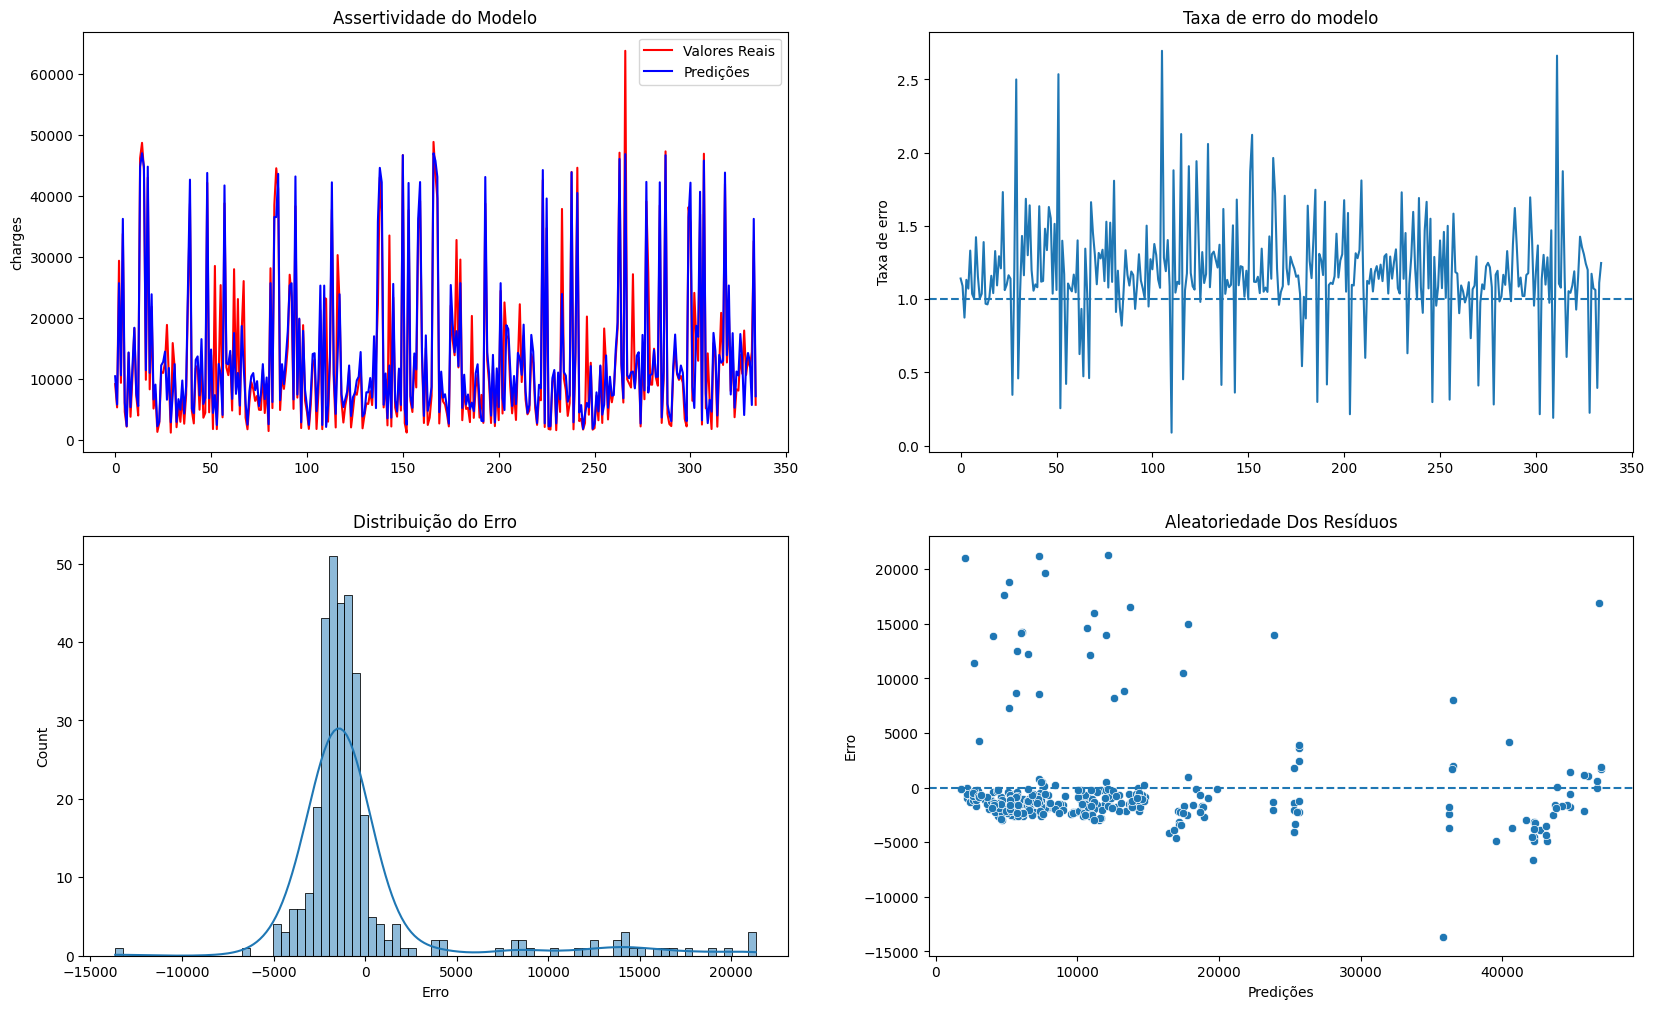

In [264]:
#seleciona o índice de cada linha
index = y_test.reset_index(drop=True).index.values

#calcula a taxa de erro
error_rate = predicoes/y_test

#calcula o erro
erro = y_test - predicoes

#cria gráfico
plt.figure(figsize=(20,12))

plt.subplot( 2, 2, 1 )
sns.lineplot( x=index, y=y_test, label='Valores Reais', c='r')
sns.lineplot( x=index, y=predicoes, label='Predições', c='b')
plt.title('Assertividade do Modelo')

plt.subplot( 2, 2, 2 )
sns.lineplot( x=index, y=error_rate )
plt.ylabel('Taxa de erro')
plt.axhline( 1, linestyle='--')
plt.title('Taxa de erro do modelo')

plt.subplot( 2, 2, 3 )
sns.histplot(erro, kde=True)
plt.xlabel('Erro')
plt.title('Distribuição do Erro')

plt.subplot( 2, 2, 4 )
sns.scatterplot( x = predicoes, y = erro)
plt.axhline( 0, linestyle='--')
plt.ylabel('Erro')
plt.xlabel('Predições')
plt.title('Aleatoriedade Dos Resíduos');

- Pode-se observar que o modelo capturou relativamente bem como a variável resposta varia

- A taxa de erro ideal seria próximo de 1, o que indica que os valores reais e preditos seriam bem próximos (já que o cálculo se da por (predição / valor real)). No gráfico é possível observar uma tendência à taxa de erro ser maior que 1 (ou seja, nosso modelo está superestimando).

- Nos dois gráficos debaixo, verificamos a distribuilçao dos erros (erro = valores reais - predições). O ideal seria que os erros estivessem aleatoriamente ao redor do zero, porém percebe-se uma assimetria à direita, o que indica que os valores previstos tendem a estar superestimados.

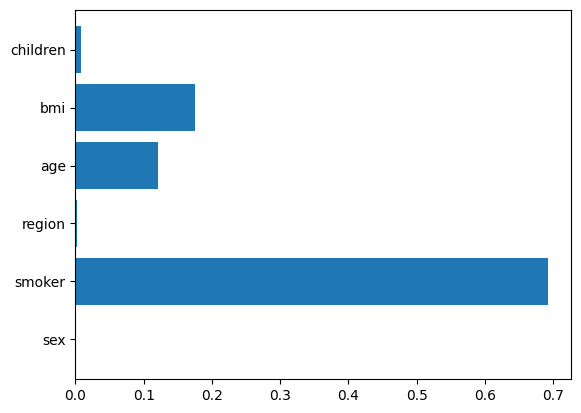

In [265]:
#feature importance
plt.barh(rf.feature_names_in_, rf.feature_importances_);

- É possível verificar que as variáveis smoker, bmi e age são as que mais impactam o nosso modelo. 